# Prepara Alta Vista Para Modelacion

Se prepara la cuenca de alta vista para que sea modelada en el SIATA en tiempo real, en este caso se preparan ambas cuencas, tanto aguas arriba como aguas abajo.

In [1]:
%matplotlib inline
from wmf import wmf 
import numpy as np
import pylab as pl
import datetime as dt
import os

In [2]:
ruta = '/media/nicolas/discoGrande/01_SIATA/'

## Alta Vista Aguas Arriba 

Se va a simular con casi todo en tipo no lineal, excepto el flujo base.

In [3]:
cu = wmf.SimuBasin(0,0,0,0, rute='/media/nicolas/discoGrande/01_SIATA/nc_cuencas/AltaVista_abajo.nc')

Parametros Geomorfológicos

In [4]:
#geomorfologia
cu.GetGeo_Cell_Basics()
cu.set_Geomorphology(stream_width=cu.CellLong, )

/usr/local/lib/python2.7/dist-packages/wmf/wmf.py:2417: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if stream_width==None:


In [5]:
cu.GetGeo_Parameters(rutaParamASC='/media/nicolas/discoGrande/01_SIATA/ParamCuencas/Param_AltaVista_Arriba.txt')

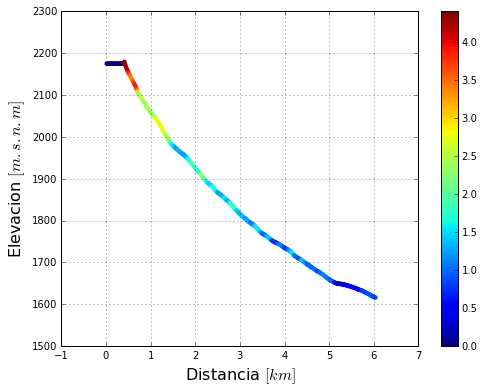

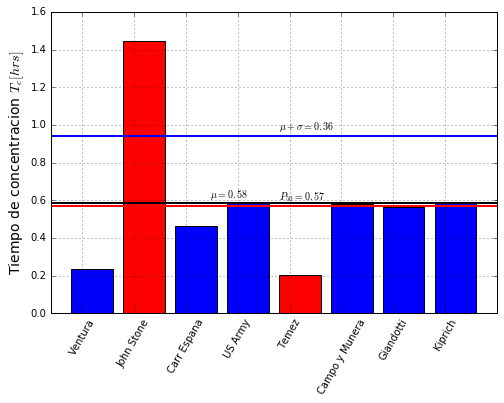

In [7]:
cu.GetGeo_Ppal_Hipsometric()
cu.PlotPpalStream(ruta=ruta + '/ParamCuencas/PerfilCauce_AltaVista_Abajo.png')
cu.Plot_Hipsometric(ruta=ruta + '/ParamCuencas/CurvaHipso_AltaVista_Aabajo.png')
cu.Plot_Tc(ruta=ruta + '/ParamCuencas/Tc_AltaVista_Abajo.png')

Parametros fisicos

/usr/local/lib/python2.7/dist-packages/wmf/wmf.py:1673: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if vec<>None:


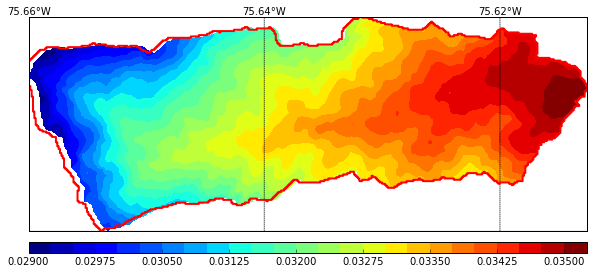

96


In [8]:
Evp=4.658*np.exp(-0.0002*cu.CellHeight)
cu.Plot_basin(Evp / 96.0)
dia5Min = 8*12 #Ocho horas de luz efectiva 
print dia5Min

Figura EVP: Evaporacion estimada cada 5 min en las 8 horas de luz efectiva para la EVP 

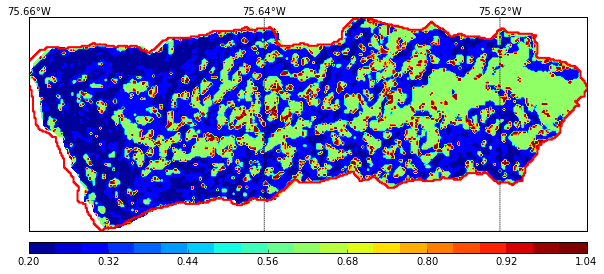

In [9]:
#Lectura de la profunidad de raiz
Z,p = wmf.read_map_raster('/media/nicolas/discoGrande/01_SIATA/raster/Prof_raiz_cm.tif')
Z = cu.Transform_Map2Basin(Z,p)
Z[Z == -9999] = 40.0
Z[Z==0]=40
#Profundidad por geomorfologia
Zg = np.zeros(cu.ncells)
Zg[cu.CellSlope<0.25]=0.6
Zg[(cu.CellSlope>=0.25)&(cu.CellSlope<0.30)]=1.0
Zg[(cu.CellSlope>=0.30)&(cu.CellSlope<0.50)]=0.3
Zg[cu.CellSlope>=0.5] = 0.2
#plot de la profundidad
cu.Plot_basin(Zg,ruta=ruta + 'ParamCuencas/Prof_suelo_AltaVistaAbajo.png')

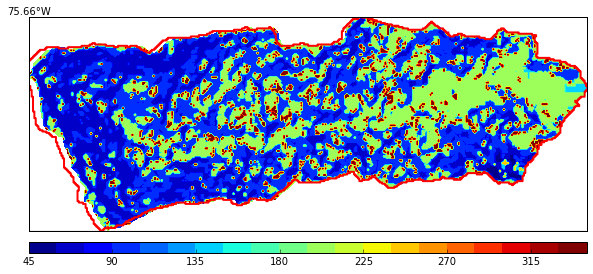

In [10]:
Tetas = {}
for i in ['Teta_pmp','Teta_cp','Teta_sat']:
    te,p = wmf.read_map_raster('/media/nicolas/discoGrande/01_SIATA/raster/'+i+'.tif')
    te = cu.Transform_Map2Basin(te,p)
    te[te == -9999] = te[te>0].mean()
    te[te == 0] = te[te>0].mean()
    Tetas.update({i:te})
# Valores de Hu y Hg calculados en metros 
Hu  = Zg * (Tetas['Teta_cp']-Tetas['Teta_pmp'])*10
Hg  = Zg * (Tetas['Teta_sat']-Tetas['Teta_cp'])*10
Hu[Z == 2] = 2
cu.Plot_basin(Hg,lines_spaces=0.08,ruta=ruta + 'ParamCuencas/Hg_AltaVista_Abajo.png')

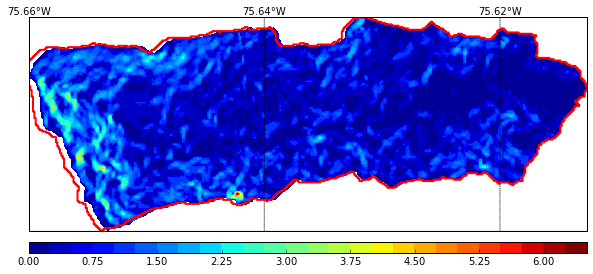

In [11]:
# Cionductividad hidraulica saturada 
Ks, p = wmf.read_map_raster('/media/nicolas/discoGrande/01_SIATA/raster/'+'Ks_mm_h.tif')
Ks = cu.Transform_Map2Basin(Ks,p)
#Conductivdad Nivel freatico 
Ks[Ks == -9999] = Ks[Ks>0].mean()
Ks[Ks == 0] = Ks[Ks>0].mean()
Kp = np.copy(Ks) / 100.0
#Coeficiente kubota y sivapalan 
ksh=((Ks/3600000.0)*cu.CellSlope*(30.0**2.0))/(3*(Hg*0.9/1000.0)**2)
cu.Plot_basin(ksh)

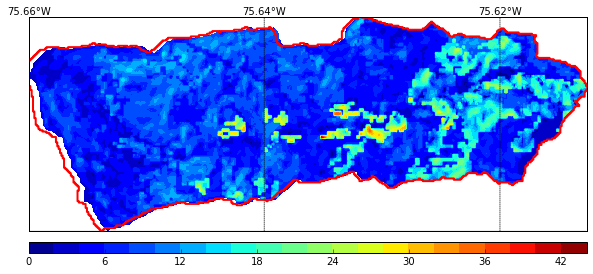

0.426666666667


In [12]:
# Rugosidad 
man,p = wmf.read_map_raster('/media/nicolas/discoGrande/01_SIATA/raster/n_man.asc')
man = cu.Transform_Map2Basin(man,p)
#Flujo por pequenos surcos 
CoefLad = (0.5/man)*(cu.CellSlope**(1.0/2.0))
ExpLad = (2.0/3.0)*0.64
cu.Plot_basin(CoefLad)
print ExpLad

/usr/local/lib/python2.7/dist-packages/wmf/wmf.py:448: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if pend<>None and area<>None:


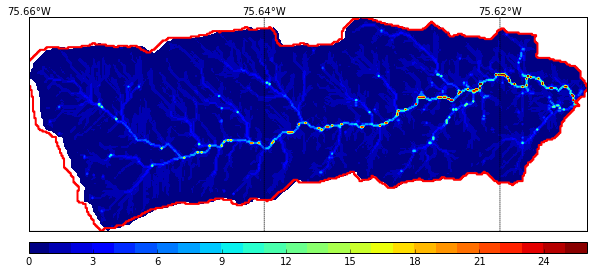

0.324655436447


In [13]:
#Coeficiente de cauces
area = cu.CellAcum * (12.7**2)/1e6 #Tamaño de celda al cuadrado
CoefOCG,ExpOCG = wmf.OCG_param(pend = cu.CellSlope, area = area)
cu.Plot_basin(CoefOCG)
print ExpOCG

montaje de los parametros verticales de la cuenca 

In [14]:
# Evaporacion, infiltracion, percolacion y perdidas
cu.set_PhysicVariables('v_coef',Evp,0)
#Infiltracion, se hace impermeable la ciudad, se pasa a [mm/seg]
KsForMap = np.copy(Ks)/3600.0
KsForMap.min()
KsForMap[Z==2] = 0.0001
cu.set_PhysicVariables('v_coef',KsForMap,1)
#Percolacion se pasa a [mm/seg]
cu.set_PhysicVariables('v_coef',Kp/3600.0,2)
#Se asume perdidas del sistema iguales a cero 
cu.set_PhysicVariables('v_coef',0,3)

Montaje de los almacenamientos maximos en la cuenca 

In [15]:
cu.set_PhysicVariables('capilar', Hu, 0)
cu.set_PhysicVariables('gravit', Hg, 1)

Montaje de las velociedades laterales 

In [16]:
#Coloca todas las velocidades en lineal 
cu.set_Speed_type([2,2,2])
# Coeficientes de velocidad horizontal 
cu.set_PhysicVariables('h_coef',CoefLad, 0)
cu.set_PhysicVariables('h_exp',ExpLad, 0) # Linealiza la ladera de nuevo 
#El flujo sub-superficial se hace no lineal 
cu.set_PhysicVariables('h_coef',ksh, 1)
cu.set_PhysicVariables('h_exp',2.0, 1)
#Coeficientes de flujo subterraneo 
cu.set_PhysicVariables('h_coef', Kp/3600, 2)
#Coeficientes de velocidad en canales 
cu.set_PhysicVariables('h_coef', CoefOCG, 3)
cu.set_PhysicVariables('h_exp', ExpOCG, 3)


In [17]:
# Guarda la version lineal 
cu.Save_SimuBasin('/media/nicolas/discoGrande/01_SIATA/nc_cuencas/AltaVista_abajo.nc',
    ruta_dem = '/media/nicolas/discoGrande/01_SIATA/raster/dem_altavista.tif',
    ruta_dir = '/media/nicolas/discoGrande/01_SIATA/raster/dir_altavista.tif')